In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



=== Processing: mishmar_hanegev_maoz_ROI_8bit_partial_preproc (100 images) ===


  0%|          | 0/100 [00:00<?, ?it/s]

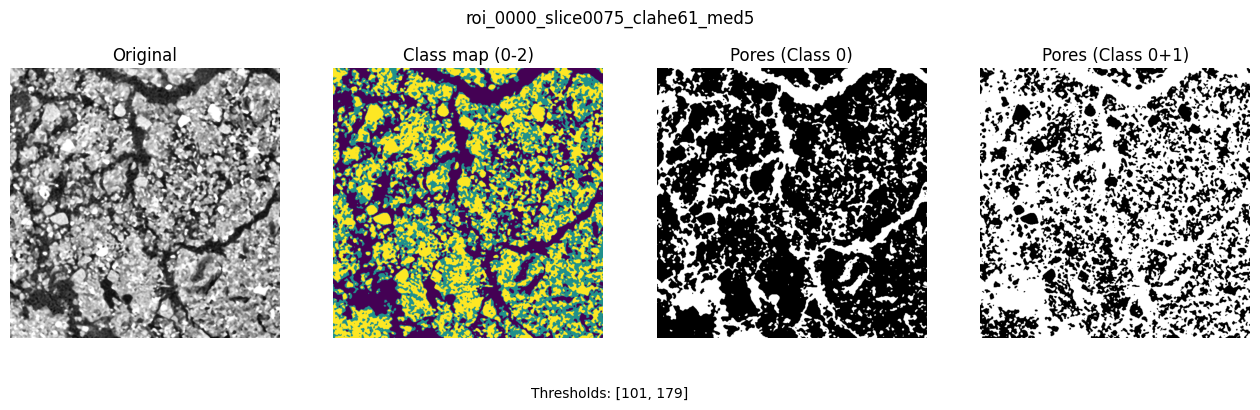

  1%|          | 1/100 [00:02<04:02,  2.45s/it]

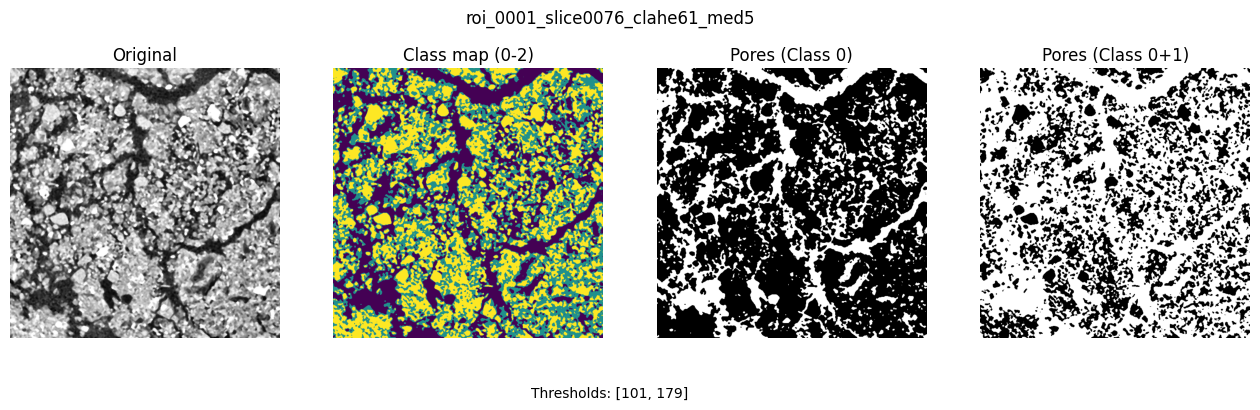

  2%|▏         | 2/100 [00:04<03:42,  2.27s/it]

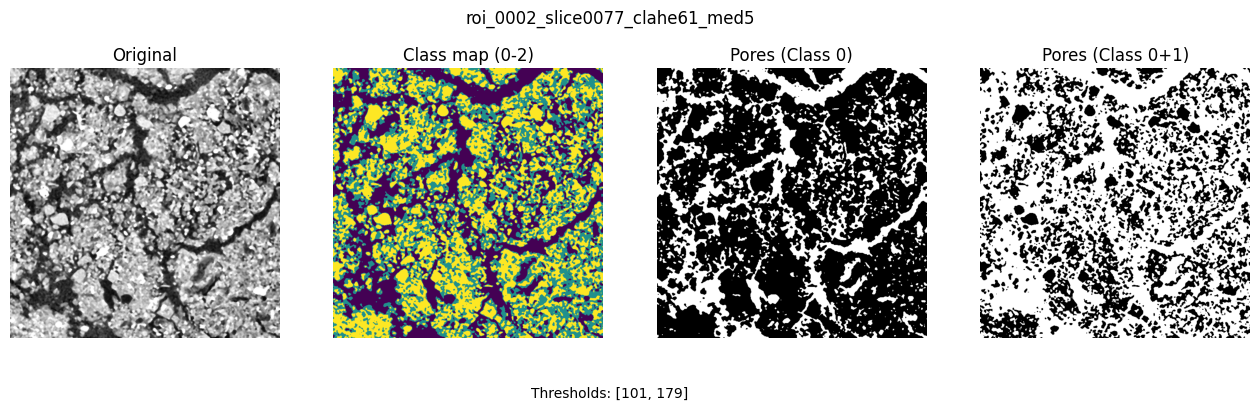

100%|██████████| 100/100 [00:42<00:00,  2.37it/s]


=== SUMMARY ===
mishmar_hanegev_maoz_ROI_8bit_partial_preproc: {'mean_T1': np.float64(100.87), 'mean_T2': np.float64(177.96)}

Done ✅


In [3]:
# =========================
# COLAB: DARK PORES SEGMENTATION - PURE MULTI-OTSU
# =========================
# 1) Reads images from input folders
# 2) Applies Multi-Otsu directly on grayscale (No filters/morphology)
# 3) Saves class map and binary masks
# =========================

!pip -q install opencv-python-headless scikit-image matplotlib tqdm

import os
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.filters import threshold_multiotsu

# -------------------------
# 1) CONFIG
# -------------------------
INPUT_FOLDERS = [
    '/content/drive/MyDrive/soil_microCT_images/ROI/maoz_scans/mishmar_hanegev_maoz_ROI_8bit_partial_preproc/'
]

OUTPUT_ROOT = '/content/drive/MyDrive/soil_microCT_images/ROI/maoz_scans/mishmar_hanegev_maoz_ROI_8bit_partial_preproc/otsu'

# Multi-Otsu settings
N_CLASSES = 3  # 3 classes => 2 thresholds

# Save overlay images too?
SAVE_OVERLAY = True

# Preview how many images per folder
PREVIEW_N = 3

# File extensions
EXTS = {".png", ".jpg", ".jpeg", ".tif", ".tiff", ".bmp"}

# -------------------------
# Helpers
# -------------------------
def ensure_dir(p: str):
    Path(p).mkdir(parents=True, exist_ok=True)

def list_images(folder: str):
    folder = Path(folder)
    files = []
    if not folder.exists(): return files
    for f in folder.iterdir():
        if f.is_file() and f.suffix.lower() in EXTS:
            files.append(str(f))
    return sorted(files)

def make_overlay(gray: np.ndarray, mask_u8: np.ndarray, alpha=0.35):
    bgr = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
    overlay = bgr.copy()
    overlay[mask_u8 > 0] = (0, 0, 255)  # Red highlight
    return cv2.addWeighted(overlay, alpha, bgr, 1 - alpha, 0)

def show_preview(gray, classmap, pores0_u8, pores01_u8, thresholds, title):
    plt.figure(figsize=(16, 4))
    plt.suptitle(title)

    plt.subplot(1, 4, 1)
    plt.imshow(gray, cmap="gray")
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.imshow(classmap, cmap="viridis")
    plt.title(f"Class map (0-{N_CLASSES-1})")
    plt.axis("off")

    plt.subplot(1, 4, 3)
    plt.imshow(pores0_u8, cmap="gray")
    plt.title("Pores (Class 0)")
    plt.axis("off")

    plt.subplot(1, 4, 4)
    plt.imshow(pores01_u8, cmap="gray")
    plt.title("Pores (Class 0+1)")
    plt.axis("off")

    plt.figtext(0.5, 0.01, f"Thresholds: {thresholds}", ha="center")
    plt.show()

# -------------------------
# 2) Main Processing
# -------------------------
ensure_dir(OUTPUT_ROOT)
stats = {}

for in_dir in INPUT_FOLDERS:
    in_dir = in_dir.strip()
    folder_name = Path(in_dir).name
    imgs = list_images(in_dir)

    print(f"\n=== Processing: {folder_name} ({len(imgs)} images) ===")

    out_dir = os.path.join(OUTPUT_ROOT, folder_name)
    out_class_dir = os.path.join(out_dir, "classmap")
    out_mask0_dir  = os.path.join(out_dir, "pores_class0")
    out_mask01_dir = os.path.join(out_dir, "pores_class0_plus_1")

    for d in [out_class_dir, out_mask0_dir, out_mask01_dir]: ensure_dir(d)

    if SAVE_OVERLAY:
        out_ov0 = os.path.join(out_dir, "overlays_class0")
        out_ov01 = os.path.join(out_dir, "overlays_class0_plus_1")
        ensure_dir(out_ov0); ensure_dir(out_ov01)

    thresholds_list = []
    preview_done = 0

    for img_path in tqdm(imgs):
        gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if gray is None: continue

        # --- PURE MULTI-OTSU ---
        try:
            thresholds = threshold_multiotsu(gray, classes=N_CLASSES)
            thresholds_list.append(tuple([float(x) for x in thresholds]))

            # Create class map (0, 1, 2)
            classmap = np.digitize(gray, bins=thresholds).astype(np.uint8)
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            continue

        # Extract Masks (No morphology/cleaning)
        pores0_u8 = ((classmap == 0).astype(np.uint8) * 255)
        pores01_u8 = ((classmap <= 1).astype(np.uint8) * 255)

        # Save Results
        base = Path(img_path).stem
        cv2.imwrite(os.path.join(out_class_dir, f"{base}_classmap.png"), classmap)
        cv2.imwrite(os.path.join(out_mask0_dir, f"{base}_mask0.png"), pores0_u8)
        cv2.imwrite(os.path.join(out_mask01_dir, f"{base}_mask01.png"), pores01_u8)

        if SAVE_OVERLAY:
            cv2.imwrite(os.path.join(out_ov0, f"{base}_ov0.png"), make_overlay(gray, pores0_u8))
            cv2.imwrite(os.path.join(out_ov01, f"{base}_ov01.png"), make_overlay(gray, pores01_u8))

        if preview_done < PREVIEW_N:
            show_preview(gray, classmap, pores0_u8, pores01_u8, thresholds.tolist(), base)
            preview_done += 1

    # Stats
    if thresholds_list:
        arr = np.array(thresholds_list)
        stats[folder_name] = {
            "mean_T1": arr[:, 0].mean(),
            "mean_T2": arr[:, 1].mean() if N_CLASSES > 2 else None
        }

print("\n=== SUMMARY ===")
for folder, s in stats.items():
    print(f"{folder}: {s}")

print("\nDone ✅")